In [1]:
import pandas as pd
from pathlib import Path
from scipy.fft import fft, fftfreq

In [2]:
ecg_data_dir = Path('../data/raw/xml')

In [3]:
len(list(ecg_data_dir.glob('*.xml')))

43511

In [4]:
# xml_file_path = list(ecg_data_dir.glob('*.xml'))[0]
xml_file_path = '../data/raw/xml/MUSE_20231122_211154_57000.xml'

In [5]:
import os
import csv
import array
import base64
import xmltodict

import numpy as np

__author__ = "Will Hewitt"
__credits__ = ["Will Hewitt"]
__version__ = "1.0.0"
__maintainer__ = "Will Hewitt"
__email__ = "me@hewittwill.com"
__status__ = "Development"

class ECGXMLReader:
    """ Extract voltage data from a ECG XML file """
    def __init__(self, path, augmentLeads=False):
        try: 
            with open(path, 'rb') as xml:
                self.ECG = xmltodict.parse(xml.read().decode('ISO-8859-1'))
            
            self.augmentLeads           = augmentLeads
            self.path                   = path

            self.PatientDemographics    = self.ECG['RestingECG']['PatientDemographics']
            self.TestDemographics       = self.ECG['RestingECG']['TestDemographics']
            self.RestingECGMeasurements = self.ECG['RestingECG']['RestingECGMeasurements']
            self.Waveforms              = self.ECG['RestingECG']['Waveform'][1]

            self.LeadVoltages           = self.makeLeadVoltages()
        
        except Exception as e:
            print(str(e))
    
    def makeLeadVoltages(self):

        num_leads = 0

        leads = {}

        for lead in self.Waveforms['LeadData']:
            num_leads += 1
            
            lead_data = lead['WaveFormData']
            lead_b64  = base64.b64decode(lead_data)
            lead_vals = np.array(array.array('h', lead_b64))

            leads[ lead['LeadID'] ] = lead_vals
        
        if num_leads == 8 and self.augmentLeads:

            leads['III'] = np.subtract(leads['II'], leads['I'])
            leads['aVR'] = np.add(leads['I'], leads['II'])*(-0.5)
            leads['aVL'] = np.subtract(leads['I'], 0.5*leads['II'])
            leads['aVF'] = np.subtract(leads['II'], 0.5*leads['I'])
        
        return leads

    def getLeadVoltages(self, LeadID):
        return self.LeadVoltages[LeadID]
    
    def getAllVoltages(self):
        return self.LeadVoltages

In [6]:
try:
    ecg_reader = ECGXMLReader(xml_file_path)
except Exception as e:
    print(f"Error during initialization: {str(e)}")

all_voltages = ecg_reader.getAllVoltages()

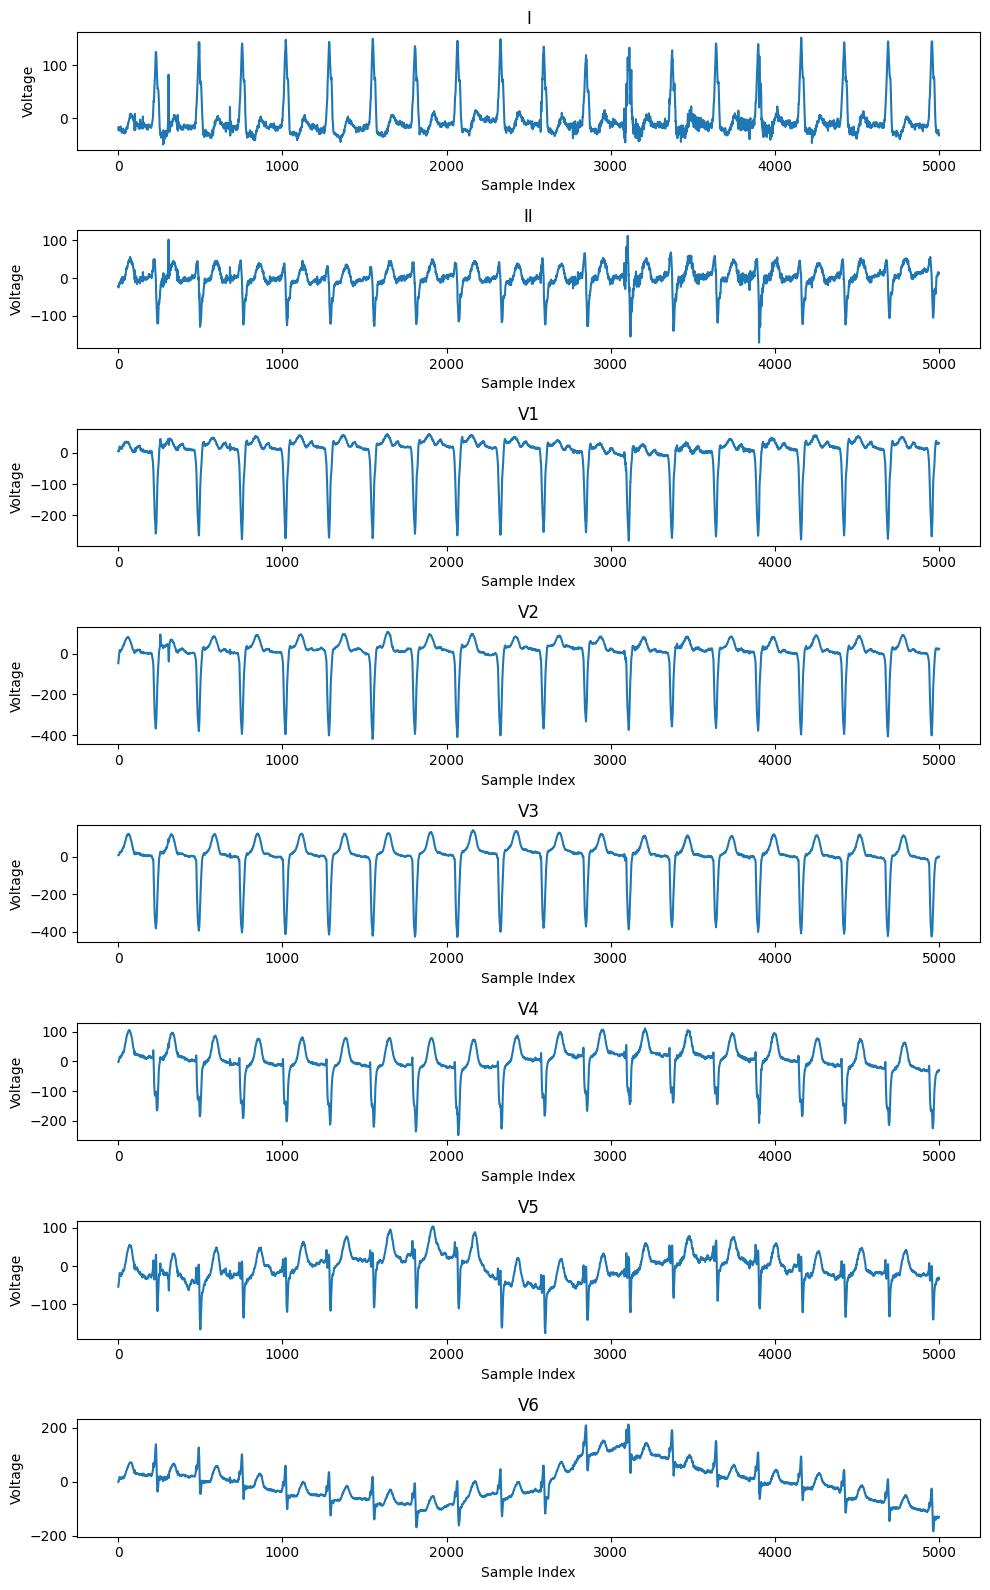

In [7]:
import matplotlib.pyplot as plt

# Number of leads
num_leads = len(all_voltages)

# Set up subplots
fig, axs = plt.subplots(num_leads, 1, figsize=(10, 2*num_leads))

# Plot each lead in a separate subplot
for i, (lead_name, lead_data) in enumerate(all_voltages.items()):
    axs[i].plot(lead_data)
    axs[i].set_title(lead_name)
    axs[i].set_xlabel('Sample Index')
    axs[i].set_ylabel('Voltage')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [8]:
my_dict = {}
arr1 = all_voltages['I']
my_dict[0] = arr1

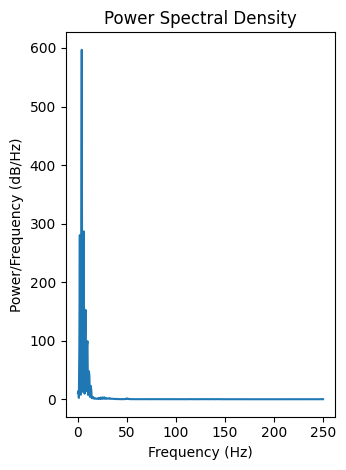

In [9]:
from matplotlib.mlab import psd

# Compute and plot the PSD
plt.subplot(1, 2, 2)
power, frequencies = psd(arr1, NFFT=1024, Fs=500)
# plt.plot(frequencies, 10 * np.log10(power))
plt.plot(frequencies, power)
plt.title('Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')

plt.tight_layout()
plt.show()

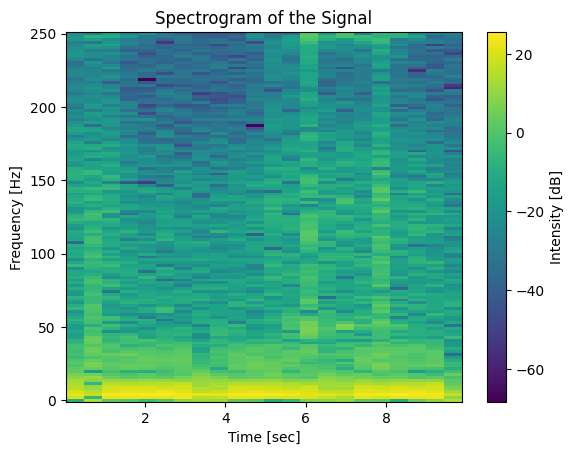

In [179]:
from scipy import signal

# Number of samples in normalized_tone
fs = 500
N = 5000

t = np.linspace(0, 1, fs, endpoint=False)  # Time vector

# Compute the spectrogram
frequencies, times, Sxx = signal.spectrogram(arr1, fs)

# Plot the spectrogram
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx))  # Convert to dB for better visualization
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram of the Signal')
plt.colorbar(label='Intensity [dB]')
plt.show()

In [180]:
# Define the bandpass filter parameters
low_cutoff = 15.0  # Lower cutoff frequency in Hz
high_cutoff = 150.0  # Higher cutoff frequency in Hz
order = 10  # Filter order

# Design the bandpass filter
b, a = signal.butter(order, [low_cutoff, high_cutoff], btype='band', fs=fs)

# Apply the bandpass filter to the signal
filtered_signal = signal.filtfilt(b, a, arr1)
my_dict[1] = filtered_signal

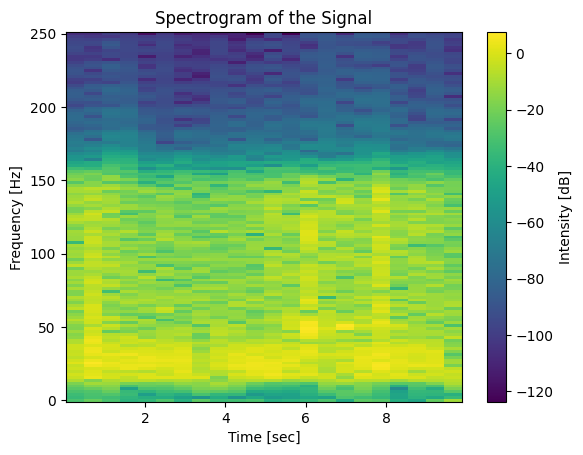

In [181]:
# Compute the spectrogram
frequencies, times, Sxx = signal.spectrogram(filtered_signal, fs)

# Plot the spectrogram
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx))  # Convert to dB for better visualization
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram of the Signal')
plt.colorbar(label='Intensity [dB]')
plt.show()

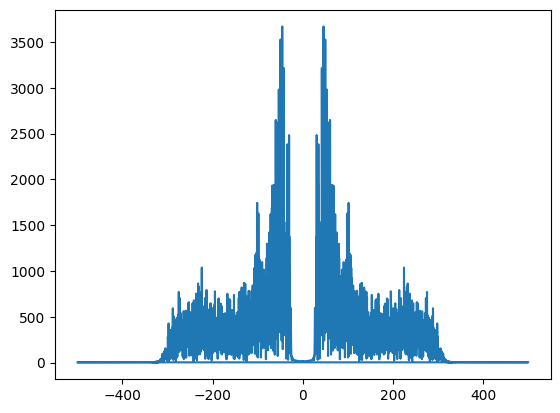

In [182]:
# Number of samples in normalized_tone
N = 5000

yf = fft(filtered_signal)
xf = fftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf))
plt.show()

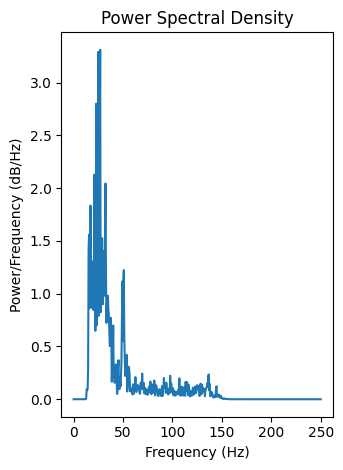

In [183]:
from matplotlib.mlab import psd

# Compute and plot the PSD
plt.subplot(1, 2, 2)
power, frequencies = psd(filtered_signal, NFFT=1024, Fs=500)
# plt.plot(frequencies, 10 * np.log10(power))
plt.plot(frequencies, power)
plt.title('Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')

plt.tight_layout()
plt.show()

In [184]:
# Define the notch filter parameters
center_frequency = 50.0  # Center frequency of the notch in Hz
bandwidth = 5  # Bandwidth of the notch in Hz
order = 4  # Filter order

# Design the notch filter
b, a = signal.iirnotch(center_frequency, bandwidth, fs=fs)

# Apply the notch filter to the signal
filtered_signal = signal.filtfilt(b, a, filtered_signal)
my_dict[2] = filtered_signal

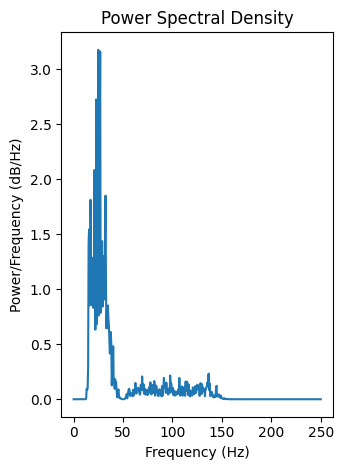

In [185]:
from matplotlib.mlab import psd

# Compute and plot the PSD
plt.subplot(1, 2, 2)
power, frequencies = psd(filtered_signal, NFFT=1024, Fs=500)
# plt.plot(frequencies, 10 * np.log10(power))
plt.plot(frequencies, power)
plt.title('Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')

plt.tight_layout()
plt.show()

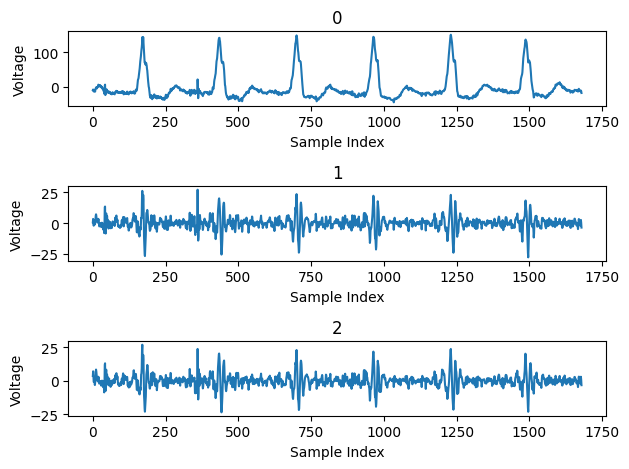

In [191]:
num_leads = len(a)

# Set up subplots
fig, axs = plt.subplots(3, 1)

# Plot each lead in a separate subplot
for i, (_,lead_data) in enumerate(my_dict.items()):
    axs[i].plot(lead_data[320:2000])
    axs[i].set_title(i)
    axs[i].set_xlabel('Sample Index')
    axs[i].set_ylabel('Voltage')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [187]:
a

array([ 1.        , -1.52226142,  0.88161859])